In [1]:
import numpy as np
import torch
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy.io import loadmat
import os
import time

class ModelVoxel(torch.nn.Module):
    def __init__(self, data, device='cpu'):
        super().__init__()
        self.data = torch.nn.Parameter(torch.tensor(data).to(device))
        
    @property
    def Ns(self):
        return self.data.shape
    @property
    def D(self):
        return len(self.data.shape)
        
    def forward(self, x):
        for i in range(self.D):
            x[:,i] = x[:,i].clamp(0, self.Ns[i]).long()
        return self.data[list(x.T)]

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [3]:
# # Importing drive method from colab for accessing google drive
# from google.colab import drive
# import glob
# drive.mount('/content/drive')
# data_files = glob.glob("/content/drive/My Drive/*.mat")

In [4]:
# data_path = '/content/drive/My Drive/' 
data_path = '/home/ab/Documents/DISK2TB/SaudiAramco/3D_geoproject/data/' 

In [133]:
tresh = 127
data3d = (loadmat(data_path+'Normal_1_0.5.mat')["ctImage"] > tresh).astype(np.float)
#bwImage = rawMatData["bwImage"]
# ctImage = rawMatData["ctImage"]
sublattice = [slice(None,512,2)]*3
data3d = data3d[sublattice]

<ipython-input-133-76fbcf0b2b25>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data3d = data3d[sublattice]


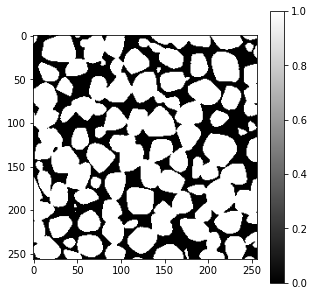

In [134]:
selection = (slice(None), slice(None), 12)

plt.figure(figsize=(5,5))
plt.imshow(data3d[selection],  cmap='gray')
plt.colorbar();

In [135]:
from ipypb import ipb
tqdm_notebook = ipb
import time

In [136]:
from torch.utils.data import Dataset, DataLoader

class discreteDataset(Dataset):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __len__(self):
        return np.prod(self.shape)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [137]:
torch_data = torch.tensor(data3d).to(device)

In [138]:
from tqdm import tqdm_notebook

In [139]:
model = ModelVoxel( torch.zeros_like(torch_data), device=device)

ds = discreteDataset(shape=data3d.shape)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds),
    batch_size=2**12,
    drop_last=False)

dl = DataLoader(ds, sampler=sampler)

<ipython-input-1-a7169f7e4a19>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.nn.Parameter(torch.tensor(data).to(device))


In [140]:
# L = torch.nn.BCELoss()
L = torch.nn.BCEWithLogitsLoss()
# L = torch.dist
n_epochs = 10
    
losses = []

for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    for epoch in ipb(range(n_epochs)):
        #print(epoch)
        for x in dl:
            optimizer.zero_grad()
            indices = torch.stack(x, dim=1).squeeze().T
            y_goal = torch_data[list(indices.T)]
            y_predicted = model(indices)
            loss = L(y_predicted, y_goal)
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(loss.detach())

 [############################################################] 0/10 [0<0, 0.00s/it]

KeyboardInterrupt: 

In [141]:
def statmoments(data):
    mu = torch.sum(data) / torch_data.numel()

In [142]:
def spacial_moments(data):
    M = torch.sum(data) / torch_data.numel()

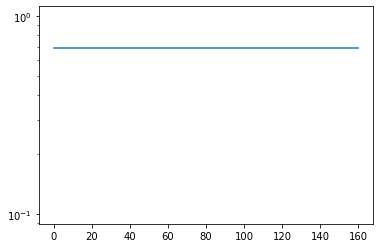

In [143]:
plt.semilogy(losses)

Text(0.5, 1.0, 'Data')

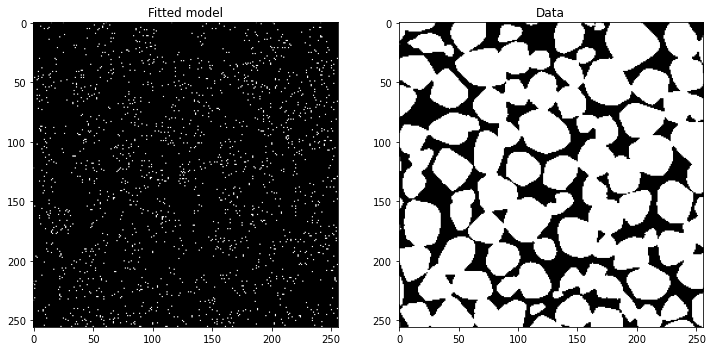

In [144]:
selection = [slice(None), slice(None), 31]
f, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(model.data[selection].sigmoid().detach().cpu().round(), cmap='gray')
axs[0].set_title("Fitted model")
axs[1].imshow(torch_data[selection].detach().cpu(), cmap='gray')
axs[1].set_title("Data")

In [145]:
import edt
def sdf(dat):
    dat = dat.astype(dtype=np.float32)
    return edt.edt(dat) - edt.edt(1.-dat)

def tsdf(dat, mu=3):
    return sdf(dat).clip(-mu, mu)

In [146]:
data_sdf = sdf(data3d)

dat = data_sdf[selection]

<ipython-input-146-a5f716102ebb>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dat = data_sdf[selection]


## Looking at Fourier harmonics

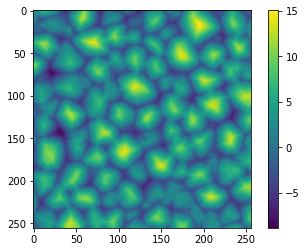

In [147]:
# plt.figure(figsize=(12,12))
plt.imshow(dat, cmap='viridis')
# plt.contour(dat, levels=[0], colors=['yellow'])
plt.colorbar()

In [148]:
import scipy

In [149]:
# torch_data2d = torch_data[selection].detach().cpu()

In [150]:
def roll(arr):
    Nx, Ny = arr.shape
    arr = np.roll(arr, axis=0, shift=Nx//2) 
    arr = np.roll(arr, axis=1, shift=Ny//2) 
    return arr

def unroll(arr):
    Nx, Ny = arr.shape
    arr = np.roll(arr, axis=0, shift=-Nx//2) 
    arr = np.roll(arr, axis=1, shift=-Ny//2) 
    return arr

In [151]:
dat_fft = roll(scipy.fft.fftn(dat))
# dat_fft[0,0]=0

In [152]:
def two_plots(a, b, cmap='viridis', titles=None):
    fig, axs = plt.subplots(1, 2,figsize=(11,11))
    if not isinstance(cmap, str):
        cmap_0 = cmap[0]
        cmap_1 = cmap[1]
    else:
        cmap_0 = cmap
        cmap_1 = cmap
        
    pcm = axs[0].imshow(a, cmap=cmap_0)
    
    fig.colorbar(pcm, ax=axs[0], fraction=.0452)
    pcm2 = axs[1].imshow(b, cmap=cmap_1)
    fig.colorbar(pcm2, ax=axs[1], fraction=.0452)
    if titles is not None:
        axs[0].set_title(titles[0])
        axs[1].set_title(titles[1])

In [153]:
dr, di = np.real(dat_fft), np.imag(dat_fft)

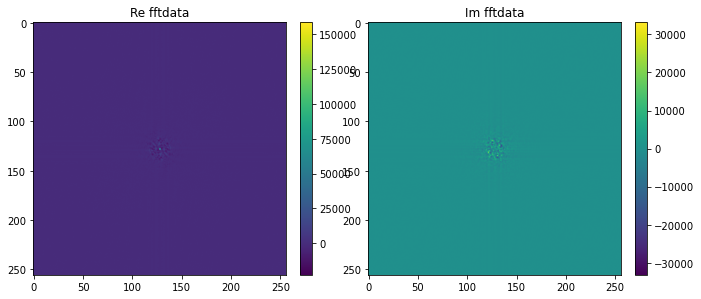

In [154]:
two_plots(dr, di, titles=['Re fftdata', 'Im fftdata'])

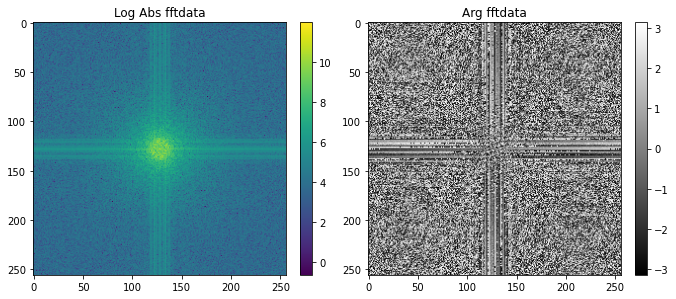

In [155]:
dabs, darg = np.abs(dat_fft), np.angle(dat_fft)
two_plots(np.log(dabs), darg, cmap=['viridis', 'gray'], titles=['Log Abs fftdata', 'Arg fftdata'])

(array([2100., 2090., 2112., 2148., 2298., 2108., 2237., 2157., 2164.,
        2181., 2223., 2257., 2175., 2296., 2222., 2224., 2295., 2176.,
        2257., 2222., 2181., 2164., 2157., 2234., 2112., 2296., 2149.,
        2112., 2090., 2099.]),
 array([-3.1415927e+00, -2.9321561e+00, -2.7227194e+00, -2.5132828e+00,
        -2.3038461e+00, -2.0944095e+00, -1.8849729e+00, -1.6755363e+00,
        -1.4660996e+00, -1.2566630e+00, -1.0472263e+00, -8.3778971e-01,
        -6.2835306e-01, -4.1891643e-01, -2.0947979e-01, -4.3153763e-05,
         2.0939349e-01,  4.1883013e-01,  6.2826675e-01,  8.3770341e-01,
         1.0471400e+00,  1.2565767e+00,  1.4660133e+00,  1.6754500e+00,
         1.8848866e+00,  2.0943232e+00,  2.3037598e+00,  2.5131965e+00,
         2.7226331e+00,  2.9320698e+00,  3.1415064e+00], dtype=float32),
 <BarContainer object of 30 artists>)

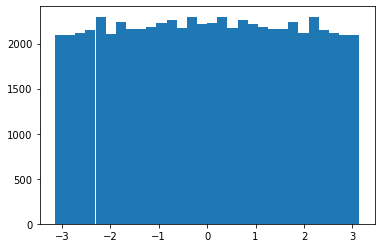

In [156]:
plt.hist(darg.flatten(), bins=30 )

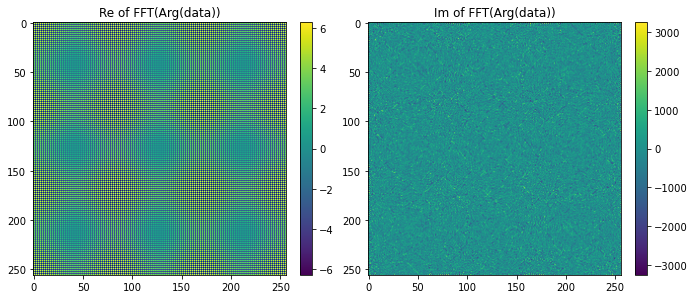

In [157]:
angle_fft = scipy.fft.fftn(darg)
two_plots(angle_fft.real, angle_fft.imag, titles=['Re of FFT(Arg(data))', 'Im of FFT(Arg(data))'])

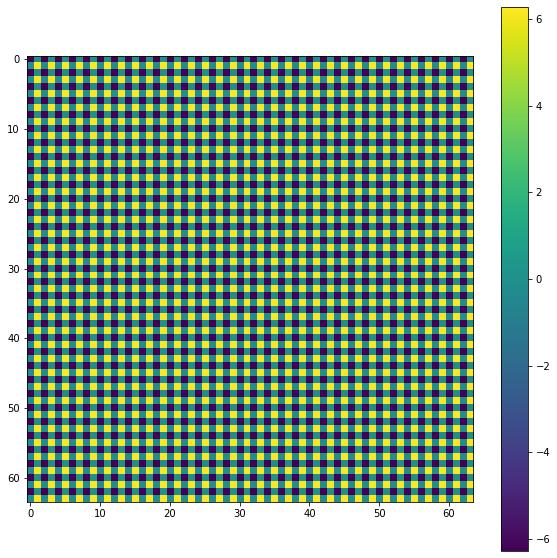

In [161]:
plt.figure(figsize=(10,10))
plt.imshow(angle_fft.real[:64, :64])
plt.colorbar()

In [163]:
np.pi*3

9.42477796076938

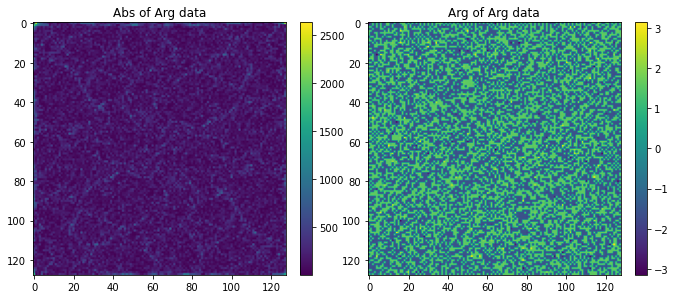

In [128]:
two_plots(np.abs(angle_fft), np.angle(angle_fft), titles=['Abs of Arg data', 'Arg of Arg data'])

In [112]:
dat_fft = scipy.fft.fftn(dat)

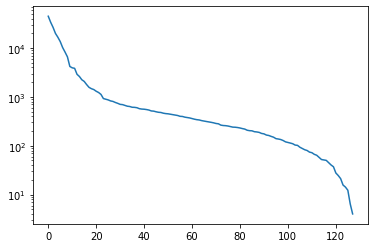

In [113]:
U, S, V = np.linalg.svd(dat_fft)
plt.semilogy(S)

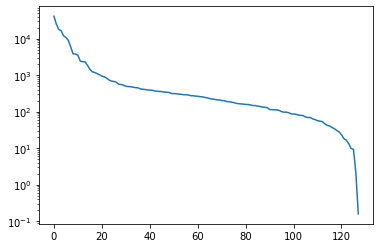

In [114]:
U, S, V = np.linalg.svd(dr)
plt.semilogy(S)

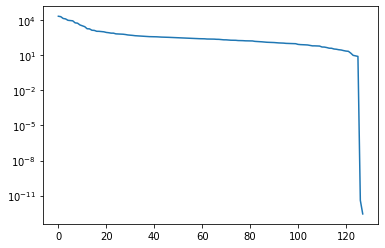

In [115]:
U, S, V = np.linalg.svd(di)
plt.semilogy(S)

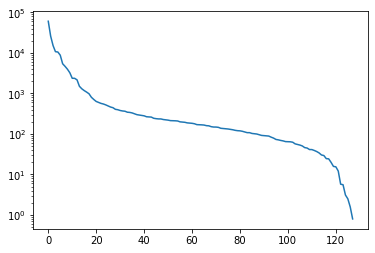

In [116]:
U, S, V = np.linalg.svd(dabs)
plt.semilogy(S)

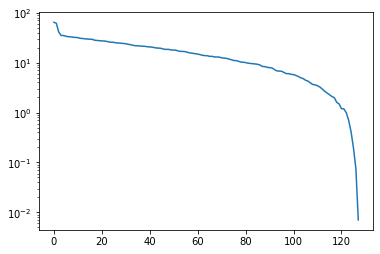

In [117]:
U, S, V = np.linalg.svd(darg)
plt.semilogy(S)

### Old experiments

In [40]:
arr2 = U.dot(np.diag(S) ).dot(V)

In [41]:
def sigmoid(x):
    return  1./(1. + np.exp(-x))

In [42]:
def unfft(arr):
    arr = unroll(arr)
    arr = np.exp(arr)
    arr = scipy.fft.ifftn(arr)
    return sigmoid(np.real(arr))

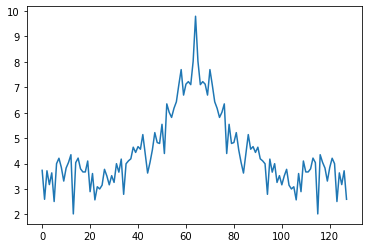

In [250]:
dat1d = []
for i in range(128):
    dat1d.append(arr[i,i])
    
plt.plot(dat1d)

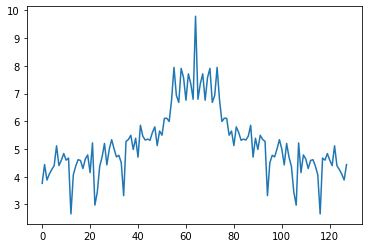

In [251]:
dat1d = []
for i in range(128):
    dat1d.append(arr[i,64])
    
plt.plot(dat1d)

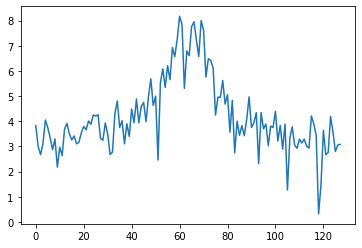

In [252]:
dat1d = []
for i in range(128):
    dat1d.append(arr[i,127-i])
    
plt.plot(dat1d)

In [ ]:
plt.imshow(np.imag(fou))
plt.colorbar()

In [ ]:
fou[0,0]=0 #removing the constant from fft
plt.imshow(np.log(np.abs(np.real(fou))))
plt.colorbar()

In [ ]:
plt.imshow(np.imag(fou))
plt.colorbar()

# Sliced dataset

In [23]:
from torch.utils.data import Dataset, DataLoader

class SlicedDataset(Dataset):
    def __init__(self, shape, mask):
        super().__init__()
        self.shape = shape
        self.mask = mask
        self.indices = np.arange(np.prod(shape))[mask.flatten()]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [24]:
# select central slices

mask = np.zeros_like(data3d, dtype=np.bool)
Nx, Ny, Nz = data3d.shape
mask[Nx//2,:,:] = True
# mask[Nx-1,:,:] = True
# mask[0,:,:] = True
mask[:,Ny//2,:] = True
# mask[:,Ny-1,:] = True
# mask[:,0,:] = True
mask[:,:,Nz//2] = True
# mask[:,:,Nz//2] = True
# mask[:,:,Nz//2] = True
ds_slices = SlicedDataset(data3d.shape, mask)

In [25]:
Z = np.prod(torch_data.shape)

In [26]:
model = torch.nn.Sequential(
                        ModelVoxel(torch.ones_like(torch_data), device=device),
#                         torch.nn.Sigmoid()
)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=2**14,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)


def optimize(model, dataloader):
    # L = torch.nn.BCELoss()
#     L = torch.nn.BCEWithLogitsLoss()

    L2 = torch.nn.MSELoss()
    Z = np.prod(torch_data.shape)   
    
    # L = torch.dist
    n_epochs = 10
    m0 = 1e-10
    m1 = 1e+2
    m2 = 1e-2
    losses = []

    for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        for epoch in ipb(range(n_epochs)):
            for x in dataloader:
                optimizer.zero_grad()
                indices = torch.stack(x, dim=1).squeeze().T
                y_goal = torch_data[list(indices.T)]
                y_predicted = model(indices)
                loss = m0*L(y_predicted, y_goal) + \
                m1*L2(torch_data.sum()/Z, model[0].data.sigmoid().sum()/Z) # + \
#                 -m2* ((.5-model[0].data.sigmoid())**2).sum()
                
                loss.backward(retain_graph=True)
                optimizer.step()
                losses.append(loss.detach())
    return losses

<ipython-input-1-a7169f7e4a19>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.nn.Parameter(torch.tensor(data).to(device))


In [27]:
losses = optimize(model, dl)

 [████████████████████████████████████████████████████████████] 10/10 [00:00<00:00, 0.03s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:00<00:00, 0.01s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:00<00:00, 0.01s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:00<00:00, 0.01s/it]

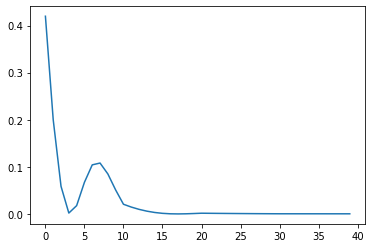

In [28]:
plt.plot(torch.stack(losses).cpu() )

Text(0.5, 1.0, 'Data')

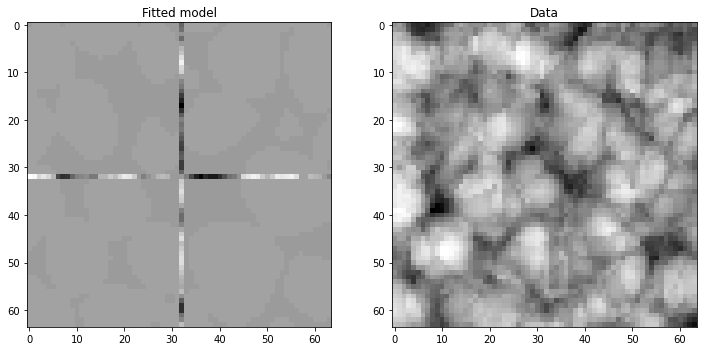

In [29]:
selection = [slice(None),  32, slice(None)]

f, axs = plt.subplots(1, 2, figsize=(12,12))
axs[0].imshow(model[0].data.sigmoid().sum(dim=0).detach().cpu(), cmap='gray')
axs[0].set_title("Fitted model")
axs[1].imshow(torch_data.sum(dim=0).detach().cpu(), cmap='gray')
axs[1].set_title("Data")

Text(0.5, 1.0, 'Data')

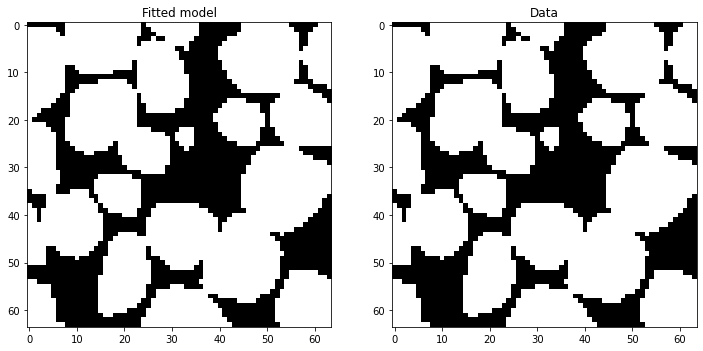

In [30]:
selection = [slice(None),  32, slice(None)]

f, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(model[0].data[selection].detach().cpu(), cmap='gray')
axs[0].set_title("Fitted model")
axs[1].imshow(torch_data[selection].detach().cpu(), cmap='gray')
axs[1].set_title("Data")

Text(0.5, 1.0, 'Data')

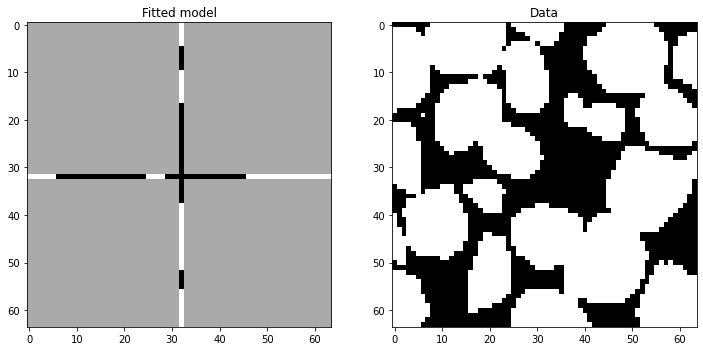

In [31]:
selection = [slice(None),  31, slice(None)]

f, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(model[0].data[selection].detach().cpu(), cmap='gray')
axs[0].set_title("Fitted model")
axs[1].imshow(torch_data[selection].detach().cpu(), cmap='gray')
axs[1].set_title("Data")

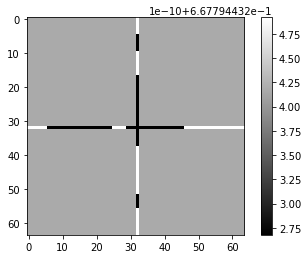

In [32]:
plt.imshow(model[0].data[selection].detach().cpu().sigmoid(), cmap='gray')
plt.colorbar()

In [33]:
model[0].data.detach().cpu().sigmoid().sum() / Z

tensor(0.6678, dtype=torch.float64)

In [34]:
torch_data.detach().cpu().sigmoid().sum() / Z

tensor(0.6539, dtype=torch.float64)

### random slices along z axis

In [35]:
# random slices along z axis

N_slices_per_axis = 10
centers = np.random.randint(Nx, size=(N_slices, 3))

mask = np.zeros_like(data3d, dtype=np.bool)
Nx, Ny, Nz = data3d.shape
mask[centers[:,0],:,0] = True
mask[:,centers[:,1],:] = True
mask[:,:,centers[:,-1]] = True
ds_slices = SlicedDataset(data3d.shape, mask)

NameError: name 'N_slices' is not defined

In [105]:
# model = ...

In [106]:
# losses = optimize(model, dl)